![softmax activation](https://images.deepai.org/django-summernote/2019-03-15/d21f6320-8c17-4c63-b4b1-47319129a4db.svg)

Notes: 

1. Since the [Sklearn MLP library](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) does not support the softmax activation function, we are implementing our neural network extention with [Keras](https://keras.io/#getting-started-30-seconds-to-keras) to emulate the simple neural network we implemnted in our homework. 

2. In our homework, we used the same activation functions for both the input and output layer. This does not work well with all activation functions. To keep thing simple, we will keep sigmoid as the input layer activation function, and experiment with different activation functoins on the output layer. 

3. Sometimes the Keras score function returns NaN, this issue is [well documented](https://github.com/keras-team/keras/issues/2134). Since we are implmenting "naive extensions" and keeping some parts of the model fixed  while "extending" others, this was not avoidable. This issue only impacted  the visualizations. 


## Set up Environment and Load Data

In [0]:
from sklearn.datasets import load_digits # The MNIST data set is in scikit learn data set
from sklearn.preprocessing import StandardScaler  # It is important in neural networks to scale the date
from sklearn.model_selection import train_test_split  # The standard - train/test to prevent overfitting and choose hyperparameters
from sklearn.metrics import accuracy_score  

import numpy as np
import numpy.random as r # We will randomly initialize our weights
import matplotlib.pyplot as plt 
import pandas as pd
import altair as alt
alt.data_transformers.disable_max_rows()

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import ELU, Activation
from keras import optimizers

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
digits = load_digits()
X = digits.data
y = digits.target
X_scale = StandardScaler()
X = X_scale.fit_transform(digits.data)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [0]:
np.isnan(np.min(X_train))
np.isnan(np.min(y_train))

False

# Digits Data

[batch size vs iterations vs epoch](https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9)

### Whats the best output layer activation function?

https://keras.io/activations/

In [0]:
batch_size = 1
num_classes = len(np.unique(y))
epochs = 5
input_shape = X_train.shape[1]
hidden_layer = 30

y_v_train = keras.utils.to_categorical(y_train, num_classes)
y_v_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
epochs = 100
activations = ['softmax', 'sigmoid', 'hard_sigmoid', 'tanh', 'softsign', 'softplus', 'relu', 'selu', 'elu']

score_arr = []

for activation in activations :
    model = Sequential()
    model.add(Dense(hidden_layer, activation='sigmoid', input_dim=input_shape))
    model.add(Dense(num_classes, activation=activation))
    model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
    run_model = model.fit(X_train, y_v_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(X_test, y_v_test))
    score = model.evaluate(X_test, y_v_test, verbose=100)
    score_arr.append(run_model.history)
    
    print(activation,'test accuracy: {0:.5}%'.format(score[1]*100))
    

softmax test accuracy: 97.556%
sigmoid test accuracy: 98.667%
hard_sigmoid test accuracy: 80.889%
tanh test accuracy: 12.444%
softsign test accuracy: 15.111%
softplus test accuracy: 98.0%
relu test accuracy: 18.889%
selu test accuracy: 11.333%
elu test accuracy: 16.667%


In [0]:
source = pd.DataFrame(score_arr, index=activations, columns = ['accuracy', 'loss', 'val_accuracy', 'val_loss'])
source.reset_index()
source = source.apply(pd.Series.explode).reset_index()
source.insert(2, 'epoch', np.tile(np.arange(1, len(score_arr[1]['loss'])+1), len(activations)))
for col in source.columns:
    try:
        source[col] = source[col].astype(float)
    except ValueError:
        pass

In [0]:
base = alt.Chart(source).mark_line().encode(
    x=alt.X('epoch:O', title='Epoch',axis=alt.Axis(labelAngle=-0)),
    y=alt.Y('loss:Q', title="Loss"),
    color='index:N',
).properties(
    height=300,
    width=500,
    title='Loss per epoch'
)

alt.layer(base, data=source)

alt.LayerChart(...)

In [0]:
base = alt.Chart(source).mark_line().encode(
    x=alt.X('epoch:O', title='Epoch',axis=alt.Axis(labelAngle=-0)),
    y=alt.Y('accuracy:Q', title="Accuracy"),
    color='index:N',
).properties(
    height=300,
    width=500,
    title='Accuracy per epoch'
)

alt.layer(base, data=source)

alt.LayerChart(...)

### Sigmoid Activation

In [0]:
batch_size = 1
num_classes = len(np.unique(y))
epochs = 5
input_shape = X_train.shape[1]
hidden_layer = 30

y_v_train = keras.utils.to_categorical(y_train, num_classes)
y_v_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
model = Sequential()

model.add(Dense(hidden_layer, activation='sigmoid', input_dim=input_shape))
model.add(Dense(num_classes, activation='sigmoid'))
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

run_model = model.fit(X_train, y_v_train, 
                      batch_size=batch_size,
                      epochs=epochs, 
                      verbose=0, 
                      validation_data=(X_test, y_v_test))

model.summary()
score = model.evaluate(X_test, y_v_test, verbose=0)
print ('Test loss:', round(score[0], 3))
print ('Test accuracy:', round(score[1], 3))

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 30)                1950      
_________________________________________________________________
dense_20 (Dense)             (None, 10)                310       
Total params: 2,260
Trainable params: 2,260
Non-trainable params: 0
_________________________________________________________________
Test loss: 0.392
Test accuracy: 0.938


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


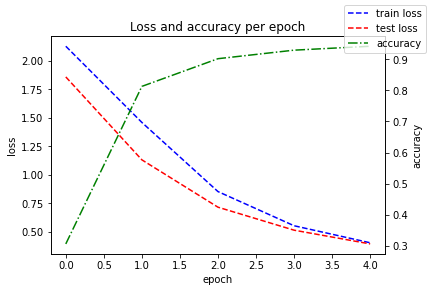

In [0]:
fig, ax = plt.subplots()
ax.plot(run_model.history['loss'], 'b--')
ax.plot(run_model.history['val_loss'], 'r--')
ax1 = ax.twinx()
ax1.plot(run_model.history['accuracy'], 'g-.')
ax1.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Loss and accuracy per epoch')

fig.legend(['train loss', 'test loss', 'accuracy'], loc='best')

## Softmax Activation

In [0]:
model = Sequential()
model.add(Dense(hidden_layer, activation='sigmoid', input_dim=input_shape))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

run_model = model.fit(X_train, y_v_train, 
                      batch_size=batch_size,
                      epochs=epochs, 
                      verbose=0, 
                      validation_data=(X_test, y_v_test))

model.summary()
score = model.evaluate(X_test, y_v_test, verbose=0)
print ('Test loss:', round(score[0], 3))
print ('Test accuracy:', round(score[1], 3))

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 30)                1950      
_________________________________________________________________
dense_22 (Dense)             (None, 10)                310       
Total params: 2,260
Trainable params: 2,260
Non-trainable params: 0
_________________________________________________________________
Test loss: 0.28
Test accuracy: 0.951


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


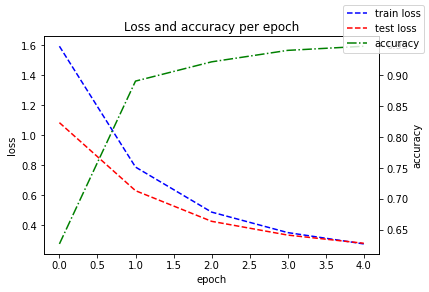

In [0]:
fig, ax = plt.subplots()
ax.plot(run_model.history['loss'], 'b--')
ax.plot(run_model.history['val_loss'], 'r--')
ax1 = ax.twinx()
ax1.plot(run_model.history['accuracy'], 'g-.')
ax1.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Loss and accuracy per epoch')

fig.legend(['train loss', 'test loss', 'accuracy'], loc='best')

# New dataset - Did it rain in Seattle?


[source](https://www.kaggle.com/rtatman/did-it-rain-in-seattle-19482017)

Original data had 25548 samples. To reduce run time, we randomly sampled a subset of the data where n=2000. This is similar to the size of the digits dataset used in homework.

Due to sampling, results may vary between runs.



In [0]:
df = pd.read_csv('/content/drive/My Drive/seattleWeather_1948-2017.csv', delimiter=',') 
df = df.dropna()
df['RAIN'] = df['RAIN'].astype('int')
df = df.drop('DATE', axis=1)
df = df.sample(n=2000, random_state=1)
y = df.pop('RAIN')
X = df
X = X_scale.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [0]:
X.shape

(2000, 3)

### Activation function iteration

In [0]:
batch_size = 1
num_classes = len(np.unique(y))
epochs = 5
input_shape = X_train.shape[1]
hidden_layer = 30

y_v_train = keras.utils.to_categorical(y_train, num_classes)
y_v_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
epochs = 50
activations = ['softmax', 'sigmoid', 'hard_sigmoid', 'tanh', 'softsign', 'softplus', 'relu', 'selu', 'elu']

score_arr = []

for activation in activations :
    model = Sequential()
    model.add(Dense(hidden_layer, activation='sigmoid', input_dim=input_shape))
    model.add(Dense(num_classes, activation=activation))
    model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
    run_model = model.fit(X_train, y_v_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(X_test, y_v_test))
    score = model.evaluate(X_test, y_v_test, verbose=100)
    score_arr.append(run_model.history)
    
    print(activation,'test accuracy: {0:.5}%'.format(score[1]*100))
    

softmax test accuracy: 97.4%
sigmoid test accuracy: 97.6%
hard_sigmoid test accuracy: 84.2%
tanh test accuracy: 41.6%
softsign test accuracy: 58.4%
softplus test accuracy: 97.2%
relu test accuracy: 41.6%
selu test accuracy: 41.6%
elu test accuracy: 41.6%


In [0]:
source = pd.DataFrame(score_arr, index=activations, columns = ['accuracy', 'loss', 'val_accuracy', 'val_loss'])
source.reset_index()
source = source.apply(pd.Series.explode).reset_index()
#source.fillna(0)
source.insert(2, 'epoch',np.tile(np.arange(1, len(score_arr[1]['loss'])+1), len(activations)))

for col in source.columns:
    try:
        source[col] = source[col].astype(float)
    except ValueError:
        pass

In [0]:
base = alt.Chart(source).mark_line().encode(
    x=alt.X('epoch:O', title='Epoch',axis=alt.Axis(labelAngle=-0)),
    y=alt.Y('loss:Q', title="Loss"),
    color='index:N',
).properties(
    height=300,
    width=500,
    title='Loss per epoch'
)

alt.layer(base, data=source)

alt.LayerChart(...)

In [0]:
base = alt.Chart(source).mark_line().encode(
    x=alt.X('epoch:O', title='Epoch',axis=alt.Axis(labelAngle=-0)),
    y=alt.Y('accuracy:Q', title="Accuracy"),
    color='index:N',
).properties(
    height=300,
    width=500,
    title='Accuracy per epoch'
)

alt.layer(base, data=source)

alt.LayerChart(...)

## Sigmoid Activation

In [0]:
batch_size = 1
num_classes = len(np.unique(y))
epochs = 5
input_shape = X_train.shape[1]
hidden_layer = 30

y_v_train = keras.utils.to_categorical(y_train, num_classes)
y_v_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
model = Sequential()

model.add(Dense(hidden_layer, activation='sigmoid', input_dim=input_shape))
model.add(Dense(num_classes, activation='sigmoid'))
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

run_model = model.fit(X_train, y_v_train, 
                      batch_size=batch_size,
                      epochs=epochs, 
                      verbose=0, 
                      validation_data=(X_test, y_v_test))

model.summary()
score = model.evaluate(X_test, y_v_test, verbose=0)
print ('Test loss:', round(score[0], 3))
print ('Test accuracy:', round(score[1], 3))

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 30)                120       
_________________________________________________________________
dense_42 (Dense)             (None, 2)                 62        
Total params: 182
Trainable params: 182
Non-trainable params: 0
_________________________________________________________________
Test loss: 0.233
Test accuracy: 0.902


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


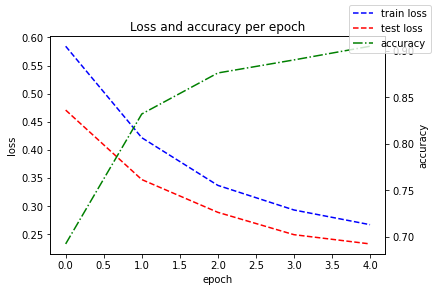

In [0]:
fig, ax = plt.subplots()
ax.plot(run_model.history['loss'], 'b--')
ax.plot(run_model.history['val_loss'], 'r--')
ax1 = ax.twinx()
ax1.plot(run_model.history['accuracy'], 'g-.')
ax1.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Loss and accuracy per epoch')

fig.legend(['train loss', 'test loss', 'accuracy'], loc='best')

## Softmax Activation

In [0]:
model = Sequential()
model.add(Dense(hidden_layer, activation='sigmoid', input_dim=input_shape))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

run_model = model.fit(X_train, y_v_train, 
                      batch_size=batch_size,
                      epochs=epochs, 
                      verbose=0, 
                      validation_data=(X_test, y_v_test))

model.summary()
score = model.evaluate(X_test, y_v_test, verbose=0)
print ('Test loss:', round(score[0], 3))
print ('Test accuracy:', round(score[1], 3))

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 30)                120       
_________________________________________________________________
dense_44 (Dense)             (None, 2)                 62        
Total params: 182
Trainable params: 182
Non-trainable params: 0
_________________________________________________________________
Test loss: 0.225
Test accuracy: 0.914


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


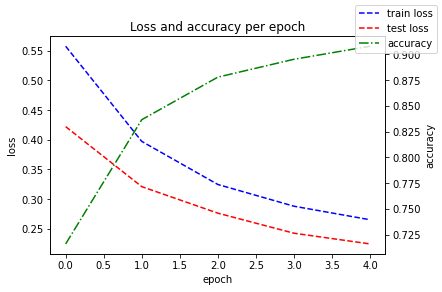

In [0]:
fig, ax = plt.subplots()
ax.plot(run_model.history['loss'], 'b--')
ax.plot(run_model.history['val_loss'], 'r--')
ax1 = ax.twinx()
ax1.plot(run_model.history['accuracy'], 'g-.')
ax1.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Loss and accuracy per epoch')

fig.legend(['train loss', 'test loss', 'accuracy'], loc='best')